# Инструкция по выполнению проекта: #

Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.

# Описание данных #
 
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

## Шаг  Загрузим данные и подготовьте их к анализу
Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный. Путь к файлам:

 -   /datasets/visits_info_short.csv. 
 -   /datasets/orders_info_short.csv. 
 -   /datasets/costs_info_short.csv.

In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
visits = pd.read_csv('/datasets/visits_info.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

### Изучим данные в таблице **visits**

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
visits.duplicated().sum()

0

In [5]:
visits.head(10)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,01.05.2019 02:36,01.05.2019 02:45
1,278965908054,United States,iPhone,organic,01.05.2019 04:46,01.05.2019 04:47
2,590706206550,United States,Mac,organic,01.05.2019 14:09,01.05.2019 15:32
3,326433527971,United States,Android,TipTop,01.05.2019 00:29,01.05.2019 00:54
4,349773784594,United States,Mac,organic,01.05.2019 03:33,01.05.2019 03:57
5,90242400005,United States,iPhone,RocketSuperAds,01.05.2019 07:14,01.05.2019 08:19
6,43958116050,United States,Android,organic,01.05.2019 09:03,01.05.2019 10:08
7,185365244969,United States,iPhone,organic,01.05.2019 09:37,01.05.2019 10:00
8,446013509831,United States,iPhone,RocketSuperAds,01.05.2019 10:26,01.05.2019 10:59
9,100970711362,United States,Mac,TipTop,01.05.2019 04:39,01.05.2019 04:57


**Вывод** Мы видим, что ни пробелов ни дубликатов в таблице visits мы не обнаружили.Заменим название столбцов на "Змеиный" регистр. Переедем данные о времени к соответствующим форматам.

In [6]:
visits['Session Start'] = pd.to_datetime(visits['Session Start'], format="%d.%m.%Y %H:%M")
visits['Session End'] = pd.to_datetime(visits['Session End'], format="%d.%m.%Y %H:%M")
#visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values] #заменяем зашлавные буквы и заполняем пробелы в названиях столбцов
visits.head(5)
#visits.info()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:00,2019-05-01 02:45:00
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:00,2019-05-01 04:47:00
2,590706206550,United States,Mac,organic,2019-05-01 14:09:00,2019-05-01 15:32:00
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:00,2019-05-01 00:54:00
4,349773784594,United States,Mac,organic,2019-05-01 03:33:00,2019-05-01 03:57:00


### Изучим данные в таблице **orders**

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [8]:
orders.duplicated().sum()

0

In [9]:
orders.head(10)

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
5,129100331057,2019-05-01 01:56:28,4.99
6,626807144131,2019-05-01 02:39:21,4.99
7,914062168985,2019-05-01 02:02:18,4.99
8,769669137453,2019-05-01 03:39:47,4.99
9,434198630691,2019-05-01 18:16:50,5.99


 **Вывод** Мы видим, что ни пробелов ни дубликтов в таблице orders мы не обнаружили.Заменим название столбцов на "змениный" регистр. Перведем данные о времени к соотвествующим форматам.

In [10]:
orders.columns = ['user_id', 'event_dt', 'revenue']

orders['event_dt'] = pd.to_datetime(orders['event_dt'], format="%Y.%m.%d %H:%M")

#orders.head()
#orders.info()

In [11]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [12]:
costs.duplicated().sum()

0

In [13]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


 **Вывод** Мы видим, что ни пробелов ни дубликтов в таблице costs мы не обнаружили.Заменим название столбцов на "змениный" регистр. Перведем данные о времени к соотвествующим форматам.

In [14]:
costs.columns = ['dt', 'channel', 'costs']
costs['dt'] = pd.to_datetime(costs['dt'], format="%Y.%m.%d" )
#costs.head()
#orders.info()

##  Шаг. Задайте функции для расчета и анализа LTV, ROI, удержания и конверсии

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

In [15]:
# функция для расчёта удержания

def get_retention(profiles,
                  sessions,
                  observation_date,
                  horizon_days,
                  dimensions = [],
                  ignore_horizon = False):
  
   # решаем какие столбцы оставим для группировки удержания, столбец признака платящего пользователя остается всегда
    dimensions = ['payer'] + dimensions

   # оттсекаем всех пользователей, которые не могли "дожить" до нужного горизонта
   # (присоединились позже чем observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

   # формируем массив сырых данных
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days


In [16]:
def group_by_dimensions(df, dims, horizon_days):    
    result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     # строим "треугольную таблицу"
    cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
    result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт к треугольной таблице
    result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждый из столбцов на размер когорты - расчитываем % удержания (retention rate)
    result = result[['cohort_size'] + list(range(horizon_days))]                                             # оставляем только наблюдения до нужного горизонта и столбец размеров когорт
    result['cohort_size'] = cohort_sizes                                                                     # пересприсваиваем столбец размеров когорт, ведь во время деления он превратился в 1
    return result


In [17]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')
    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [18]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [19]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [20]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
  # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # что мы здесь делаем???
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [21]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [22]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')
    
     # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')
    
      # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [23]:
 # функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

## Шаг. Проведите исследовательский анализ данных

Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясните:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

### Создадим профили пользователей. Определим минимальную и максимульную дату привленчения пользователей.

In [24]:
# добавляем параметр ad_costs — траты на рекламу
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles
    

In [25]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5))

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:00,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:00,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:00,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:00,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


### Определим минимальную и максимальную дату привлечения пользователей.

In [26]:
observation_date = profiles['dt'].max()  #момент анализа
display(observation_date)

Timestamp('2019-10-27 00:00:00')

In [27]:
min_observation_date = profiles['dt'].min()  
display(min_observation_date)

Timestamp('2019-05-01 00:00:00')

**Вывод**: минимальная дата привлечения Клиентов: 5 Мая 2019 г, а максимальная дата 27 Октября 2019 г.

### Определим из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?

In [28]:
##region_count=profiles.pivot_table(index='region', values='user_id', aggfunc='count')
##display(region_count.sort_values(by='user_id', ascending=False))


In [29]:
region = profiles.groupby('region').agg({'user_id': 'nunique', 'payer':['sum', 'mean']})
region1= region.sort_values(by = 'region', ascending = False).style.format({'Платящие пользователи': '{:.0f}', '% платящих': '{:.2%}'})
display(region1)

**Вывод**: Наибольшее кол-во пользователей находятся в Америке. Там же наибольшее кол-во платящих пользователь находятся в США. Далее идет Англия. Далее примерно с одинаковыми показателями идут Германия и Франция. Можно сделать вывод, что основные пользователи нашего приложения англоговорящие.

### Опредлим какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?

In [30]:
profiles.groupby('device').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)

,user_id
device,
iPhone,54479
Android,35032
PC,30455
Mac,30042


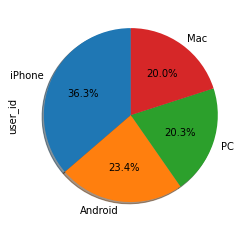

In [31]:
profiles.groupby('device').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False).plot.pie(subplots=True, legend=None,autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()


In [32]:
profiles.query('payer == True').groupby('device').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)

,user_id
device,
iPhone,3382
Android,2050
Mac,1912
PC,1537


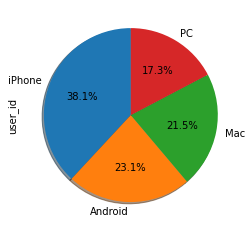

In [33]:
profiles.query('payer == True').groupby('device').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False).plot.pie(subplots=True, legend=None,autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()


**Вывод**: Пользовтели нашего приложения в осноном пользуются iPhone(в основном) и Android. Т.е это люди которые используют мобильные устройства. При этом мы видим, что кол-во пользовтатель PC и Mac меняются местами, когда дело доходит до оплаты. На это стоит обратить внимание, но не думаю, что это сильно влияет на конечный результат.

### Проверим, по каким рекламные каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [34]:
profiles.groupby('channel').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)

,user_id
channel,
organic,56439
FaceBoom,29144
TipTop,19561
OppleCreativeMedia,8605
LeapBob,8553
WahooNetBanner,8553
RocketSuperAds,4448
MediaTornado,4364
YRabbit,4312


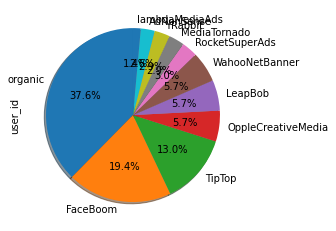

In [35]:
profiles.groupby('channel').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False).plot.pie(subplots=True, legend=None,autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()


In [36]:
profiles.query('payer == True').groupby('channel').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)




,user_id
channel,
FaceBoom,3557
TipTop,1878
organic,1160
WahooNetBanner,453
AdNonSense,440
RocketSuperAds,352
LeapBob,262
OppleCreativeMedia,233
lambdaMediaAds,225


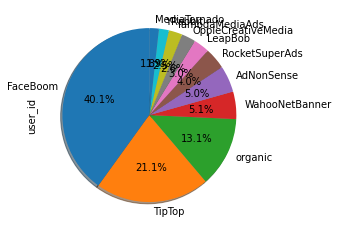

In [37]:
profiles.query('payer == True').groupby('channel').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False).plot.pie(subplots=True, legend=None,autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

**Вывод**: Мы видим, что наибольшее кол-во заходов в приложение это "органические" заходы(56439), затем с FaceBoom(29144) и TipTop (19561). При этом лучше пользователи конвертируются в конверсии с FaceBoom(3557), затем TipTop (1878)и уже потом organic(1160). Возможно на этих площадках хорошо работает наша реклама, или это контекстная реклама купленная на этих площадках.

## Шаг. Маркетинг

Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

### Посчитайте общую сумму расходов на маркетинг. Выясните, как траты распределены по источникам. Визуализируем изменения метрик во времени.


In [38]:
costs.describe()


,costs
count,1800.000000
mean,58.609611
std,107.740223
min,0.800000
25%,6.495000
50%,12.285000
75%,33.600000
max,630.000000


In [39]:
costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


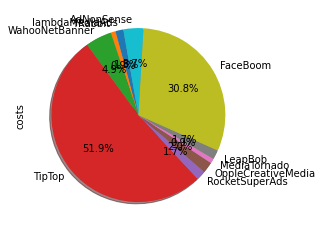

In [40]:
costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='channel', ascending=False).plot.pie(subplots=True, legend=None,autopct='%1.1f%%', shadow=True, startangle=100)
plt.show()

**Вывод**: Максимально тратим на рекламу 630 долларов,а минимально 0.8 долларов, при этом медианное значение всего 12 долларов, а среднее 58.6 долларов. Самые большие суммы тратятся на рекламу в сети TipTop (54751.30 долларов), затем на FaceBoom (32445.60 долларов) и далее WahooNetBanner (5151.00 долларов) В целом все рационально, т.к. из выводов которые мы сделали ранее, видно, что клиенты пришедшие с этих платформ наиболее платёжеспособные.
Построим график распределения трат на рекламу каждого устройства в зависимости от времени.

Построим график распределения трат на рекламу каждого устройства в зависмоти от времени.

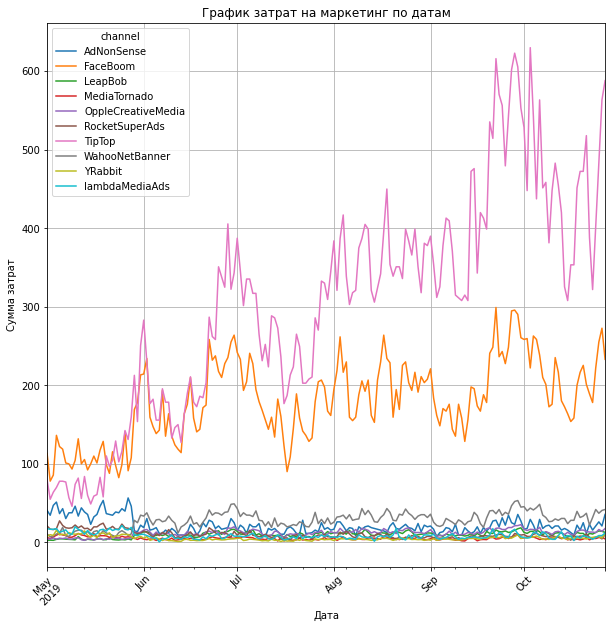

In [41]:
costs.pivot_table(
        index='dt', columns='channel', values='costs', aggfunc='sum'
    ).plot(                                             
           figsize=(10, 10), 
           grid=True, 
           rot=45,        
           label='Каналы',                       
           legend=True) 


plt.title('График затрат на маркетинг по датам')
plt.xlabel('Дата')
plt.ylabel('Сумма затрат')
plt.show()

**Вывод**:  Самые крупные траты были сделаны во второй половине сентября. Возможно была запущена крупная рекламная компания. Безусловно, что бы понять на сколько эффективно тратятся деньги на рекламу нужно считать сопутствующие метрики.  

## Шаг. Оцените окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Проанализируем общую окупаемость рекламы

Вызовим функции get_ltv() и plot_ltv_roi()

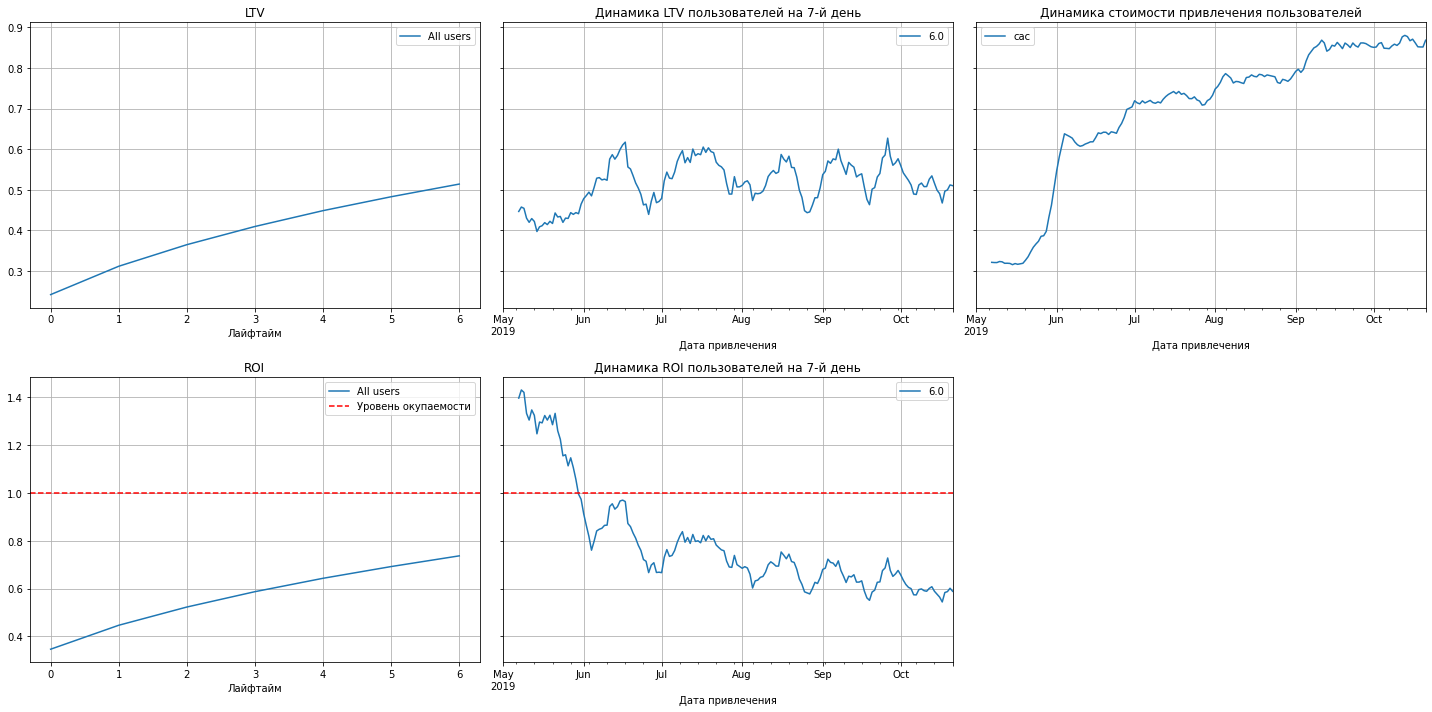

In [42]:
observation_date = datetime(2019, 10, 27).date()  
horizon_days = 7

# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 


**Вывод**: Рекламные компании не окупаются. Мы видим, что в мае реклама окупалась, но в июне начал падать и продолжал падать все остальное время. Динамика стоимости привлечения растет, что в принципе нормально.LTV нестабильный. Необходимо уточнить, почему так происходит.

### Проанализируйте окупаемость рекламы с разбивкой по устройствам;


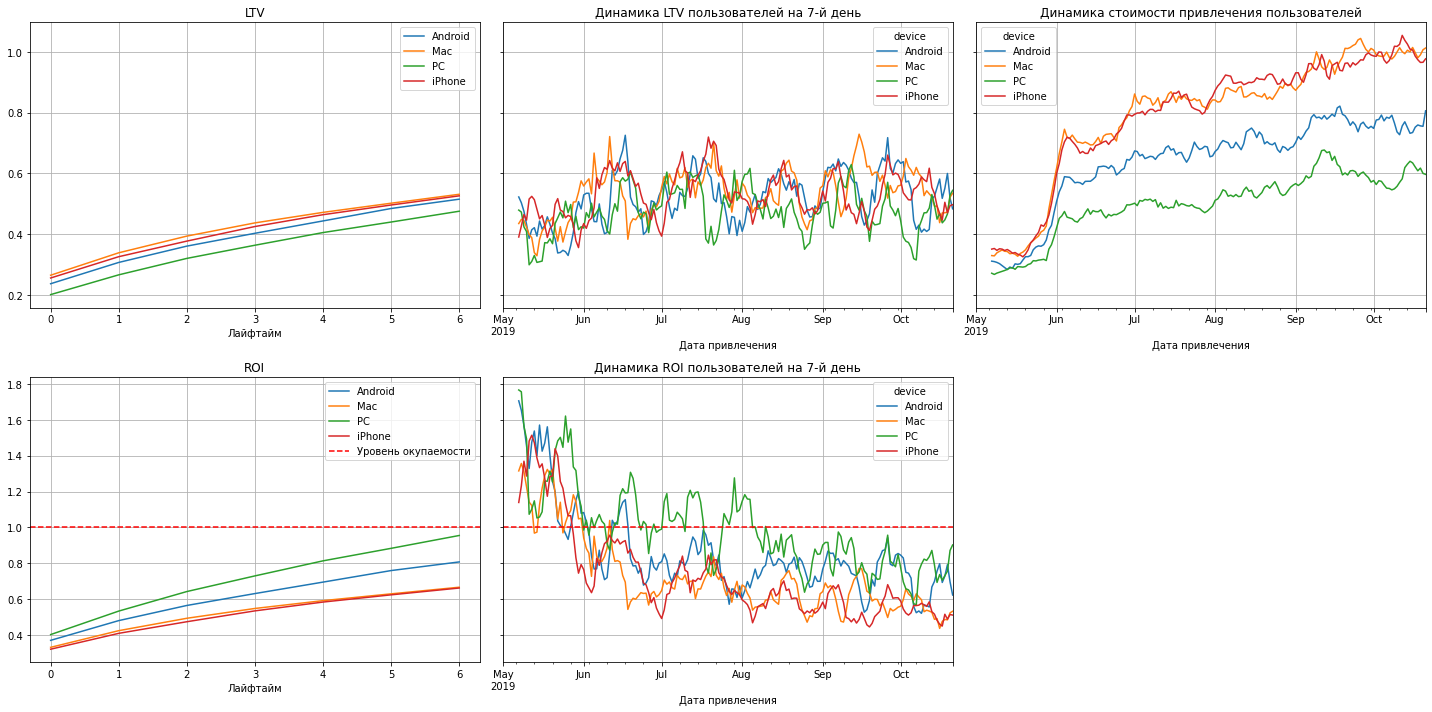

In [43]:

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
) 

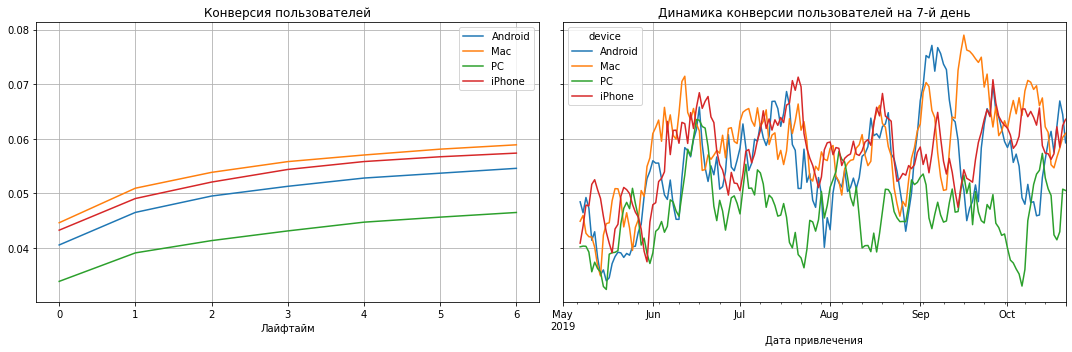

In [44]:
dimensions = ['device']
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

**Вывод** Мы видим, что по всем устройствам такая же история, в июне ROI начинает падать. CAC после июня, тоже начинает идти волнообразно, а в мае рос более или менее стабильно. ROI для PС выше всех, при этом стоимость привлечения меньше всех.

До этого мы считали, что наибольшее кол во пользователей это обладатели iphone и Android. Тут мы видим, что ROI для iphone самый низкий и динамика такая же как и у Mac. Скорей всего потому, что там одна операционная система. При этом CAC для iphone и Mac самые большие. Другими словами, деньги на рекламу мы тратим для Iphone И Mac, видим что там самое большое кол-во пользователей, а реклама на самом деле не окупается.

Нужно обратить внимание, на устройства PC. Там ROI переодически превышает единицу и в целом стремится к ней. При этом затраты небольшие

По графику конверсии мы видим, что конверсия для iphone и Mac хорошая, но денег это не приносит, либо приносит недостаточно.

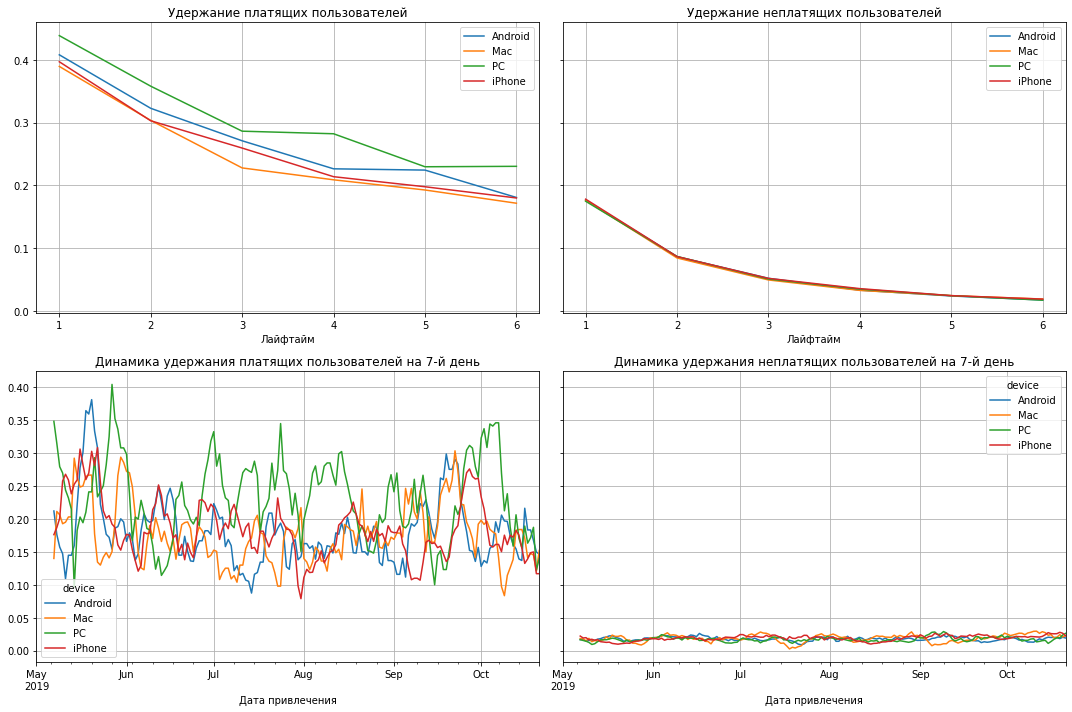

In [45]:
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Вывод**: у платящих пользователей хуже всего удержание для iPhone и Mac. Возможно потому, что это одна операционная система. Лучше всего удерживается пользователь на PC.Для неплатящих пользователей динамика по всем устройствам одинаковая.

### Проанализируем окупаемость рекламы с разбивкой по странам;


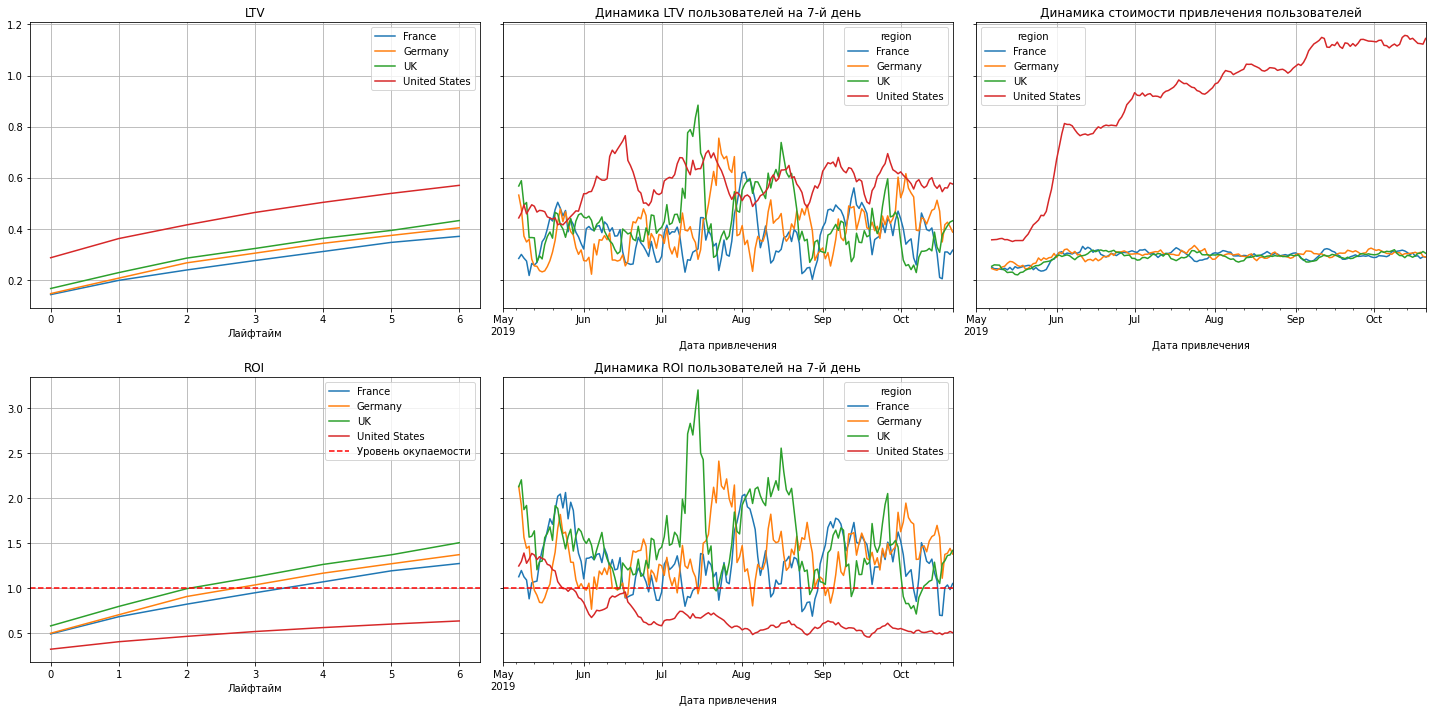

In [46]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
) 

**Вывод** В стране откуда основная масса наших пользователь, не окупается реклама. Мы видм, что ROI  значительно ниже единицы, опять же в конце мая.LTV в США достататочно хорошая. При это стоимость привлечения пользователей самая большая и постоянно растет. Реклма которая окупается показывается в Британии и Германии. ъ

Проверим конверсию по странам, чтобы понять почему в США такие плачевные показатели.

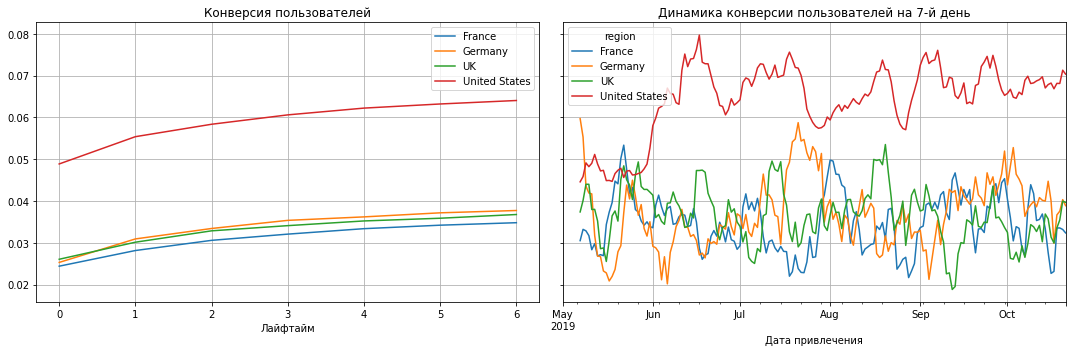

In [47]:

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

**Вывод**: Реклама для США приносит хорошую конверсию, но ROI такой низкий. Скорей всего дело в том что траты на рекламу првышают LTV от пользователь. 

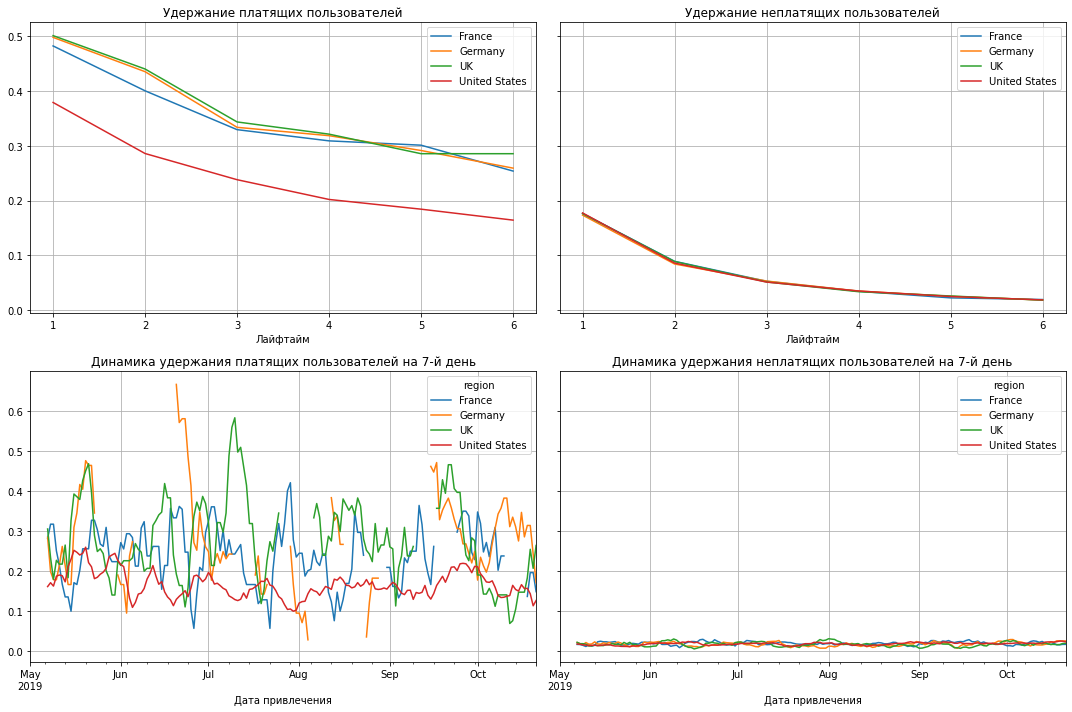

In [48]:
dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Вывод**:  Удержание и платящих и неплатящих пользователей постоянно уменьшается.И хуже всего эти показатели у США. 

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

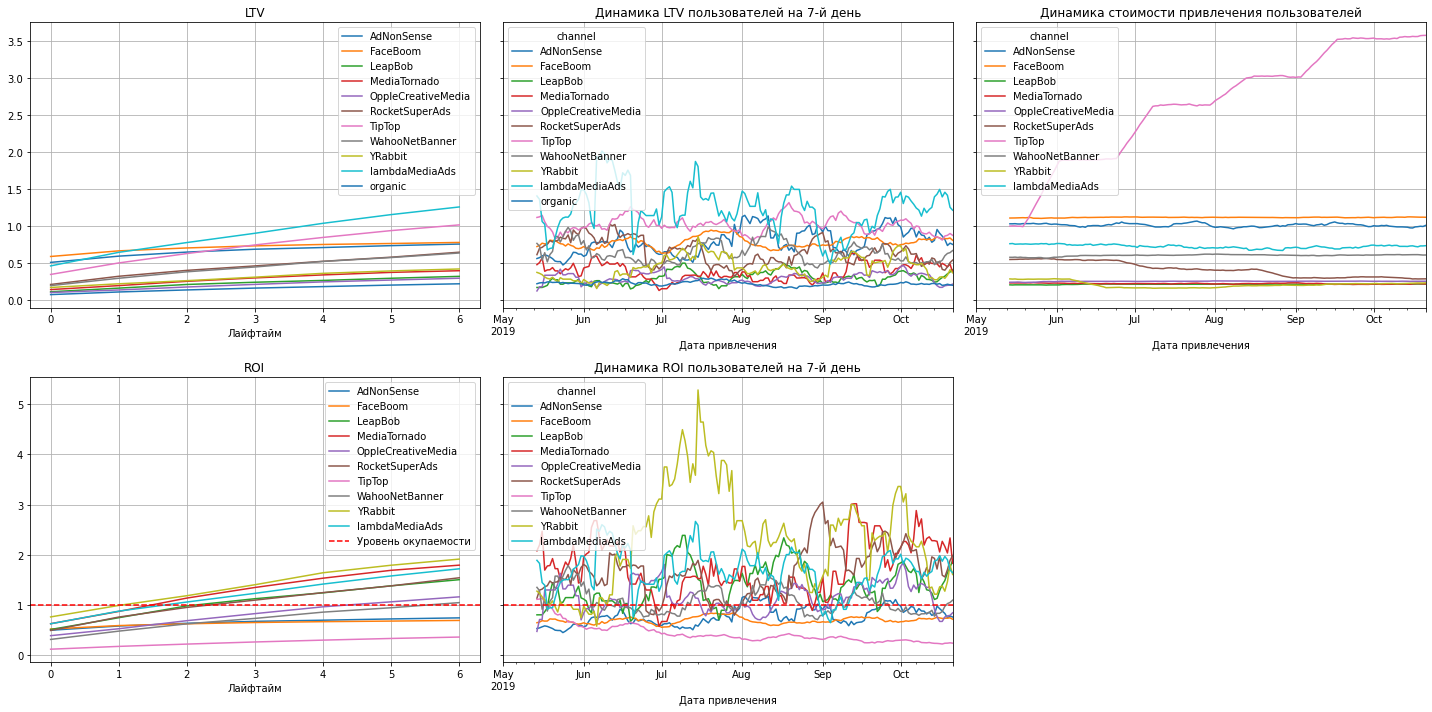

In [49]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

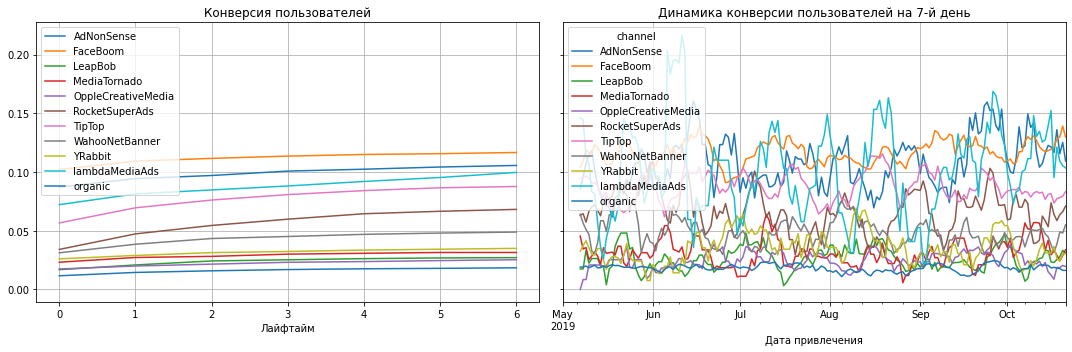

In [50]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

**Вывод** Реклама для площадок TipTop и FaceBoom не окупается.А это те площадки с которых на наше приложение заходит больше всего народу.Но мы видим, что ROI меньше единицы.Так же не окупается площадка AdNonSence, но там ROI иногда поднимается до уровня окупаемости. При этом мы видим, что затраты на рекламу TipTop постоянно и  сильно растут и конверсия тоже есть. Мы тратим слишком много денег на рекламу, при этом привлеченые пользователи не приносят столько днеег, что бы мы смогли окупит ее. 

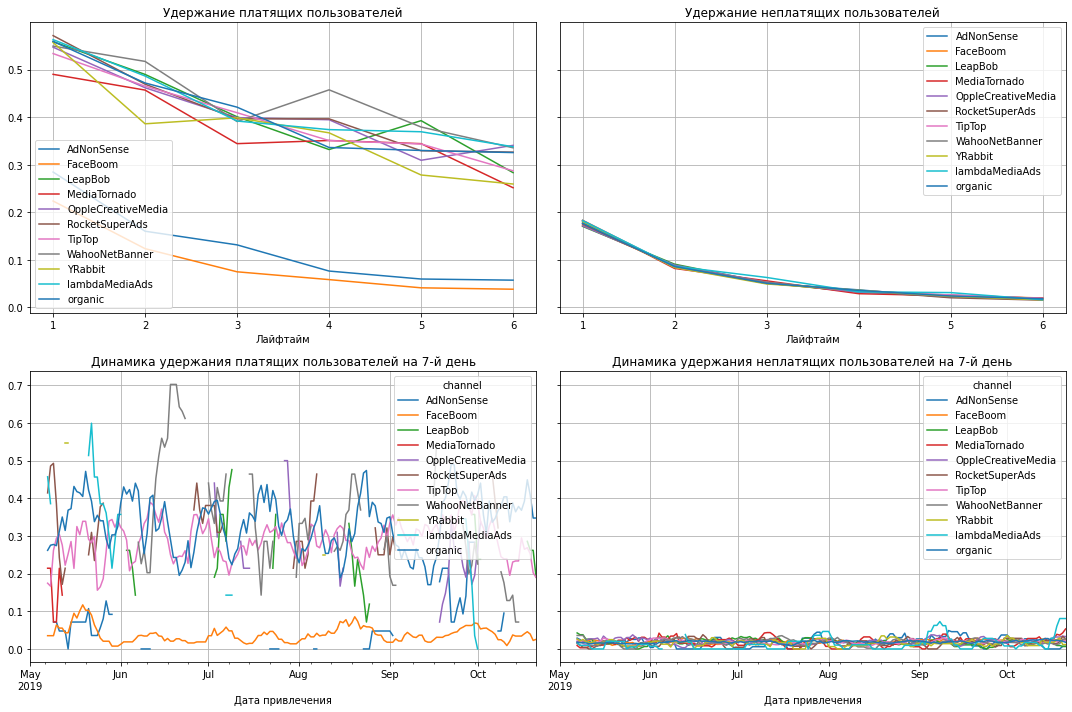

In [51]:
dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Вывод** Динамика удержания у платящих пользователей хуже всего у каналов FaceBoom и AdNonSense. Необходимо обратиить на них внимание. У неплатящих пользователей динамика у всех каналов одинаковая.

Мы видим, что очень хорошо себя вкдет реелама на площадке YRabbit, MediaTornado, lambdaMediaAds. Высокий Roi, низкие затраты. Но мы видим, что конверсия хорошая только у lambdaMediaAds. Значит нашим маркетологам нужно проработать площадки YRabbit, MediaTornado более тщательно.

# Шаг 6. Напишим выводы
Рекламные компании не окупаются. Мы видим, что в мае реклама окупалась, но в июне начал падать и продолжал падать все остальное время. Динамика стоимотси привлечения растет, что в принципе нормально.LTV нестабильный.

По разбивке по устройства видно, что затраты на рекламу постоянно растут, при этом ROI для них постоянно падает. Лидером падения является Iphone и Mac. До этого мы считали, что наибольшее кол во пользователей это обладатели iphone и Android. Тут мы видим, что ROI для iphone самый низкий и динамика такая же как и у Mac. Скорей всего потому, что там одна операционная система. При этом CAC для iphone и Mac самые большие. Другими словами, деньги на рекламу мы тартим для Iphone И Mac, видим что там самое большое кол-во пользователей, а реклама насамом деле не окупается. LTV для всех устройств примерно одинаковый.
По графику конверсии мы видим, что конверсия для iphone и Mac хорошая, но денег это не приносит, либо приносит недостаточно.
В стране откуда основная масса наших пользователь, не окупается реклама. Мы видим, что ROI значительно ниже единицы, опять же в конце мая.LTV в США достаточно хорошая. При это стоимость привлечения пользователей самая большая и постоянно растёт. Реклама которая окупается показывается в Британии и Германии.

Реклама для площадок TipTop и FaceBoom не окупается.А это те площадки с которых на наше приложение заходит больше всего народу.Но мы видим, что ROI меньше единицы.Так же не окупается площадка AdNonSence, но там ROI иногда поднимается до уровня окупаемости. При этом мы видим, что затраты на рекламу TipTop постоянно и сильно растут и конверсия тоже есть. Мы тратим слишком много денег на рекламу, при этом привлечённые пользователи не приносят столько денег, что бы мы смогли окупит ее. Мы видим, что очень хорошо себя вкдет реклама на площадке YRabbit, MediaTornado, lambdaMediaAds. Высокий Roi, низкие затраты. Но мы конверсия хорошая только у lambdaMediaAds. Значит нашим маркетологам нужно проработать площадки YRabbit, MediaTornado более тщательно.

Необходимо обратить внимание:

 - реклама на Iphone и Mac не окупается, очень много тратим денег, но получаем очень маленький выхлоп. Необходимо оптимизировать бюджеты на рекламы. (Провести A-B тесты или изменить креативы например). При этом LTV для всех устройствах примерно одинаковый. Нужно обратить внимание, на устройства PC. Там ROI переодически превышает единицу и в целом стремится к ней. При этом затраты небольшие. Можно попробовать увеличить рекламный бюджет на PC.

- очень много денег вкладываем в рекламу на США. При том, что основные пользователи от туда, реклама не окупается. При этом реклама на Англию, Германию и Францию работает хорошо. Думаю нужно переложить часть бюджета из США на эти страны и посмотреть на эффект. Безусловно оптимизировать рекламу на США.


- по площадкам очень много денег тратим на TipTop, предлагаю переложить часть средств на более окупаемые YRabbit, MediaTornado, lambdaMediaAds.

Ну и в целом в июне мы стали слишком много тратить на рекламу, раздувая бюджет на рекламу, основываясь только на данные о количестве пользователей, а не качество рекламных компаний. Необходимо пересмотреть расход бюджета из рекомендаций выше.
